In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers

from utils import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# We don't use THRESHOLD_TEST.txt file, because it's samples taken from THRESHOLD_ALL.txt 
train_dataset = np.loadtxt("data/khasanshin/THRESHOLD_ALL.txt", delimiter=",")

In [4]:
# let`s see to 4-th column
X = train_dataset[:,0:600]
Y = train_dataset[:,600]

X_train, y_train, X_val, y_val = random_split_train_val(X, Y, 212)

In [5]:
# 4-th column = sum of 1,2,3 columns
x = X_train[1].reshape(4, 150)
xyz_sum = np.sum(x[:3, :], axis=0)
np.linalg.norm(xyz_sum - x[3])

0.06480740698407855

In [6]:
# no need for features linear combination 
X = train_dataset[:,0:450]
Y = train_dataset[:,600]

X_train, y_train, X_val, y_val = random_split_train_val(X, Y, 212)

In [8]:
# Выходной слой с 5 - прямой, боковой, апперкот, уракен, передвижения без ударов
num_classes = 5
names = ['YT', 'MT', 'AT', 'U', 'NP']

Take a look to the train and validation sets, we can see a little disbalance.

In [9]:
bins_train = np.bincount(y_train.astype(np.int))
bins_val = np.bincount(y_val.astype(np.int))
idx = np.arange(len(names))

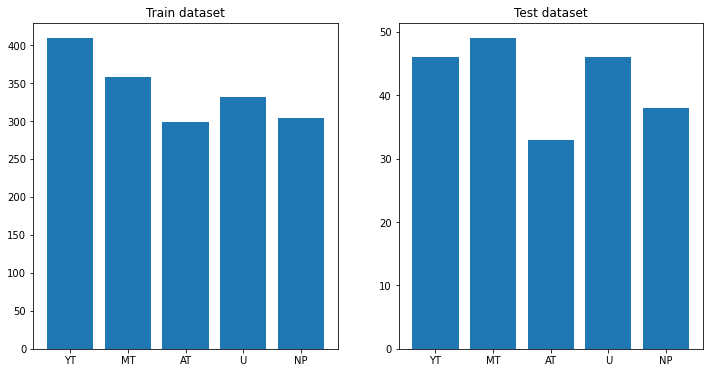

In [10]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title('Train dataset')
plt.bar(idx, bins_train)
plt.xticks(idx, names)

plt.subplot(1, 2, 2)
plt.title('Test dataset')
plt.bar(idx, bins_val)
plt.xticks(idx, names)
plt.show()

Measurement raw data visualized for different punch classes

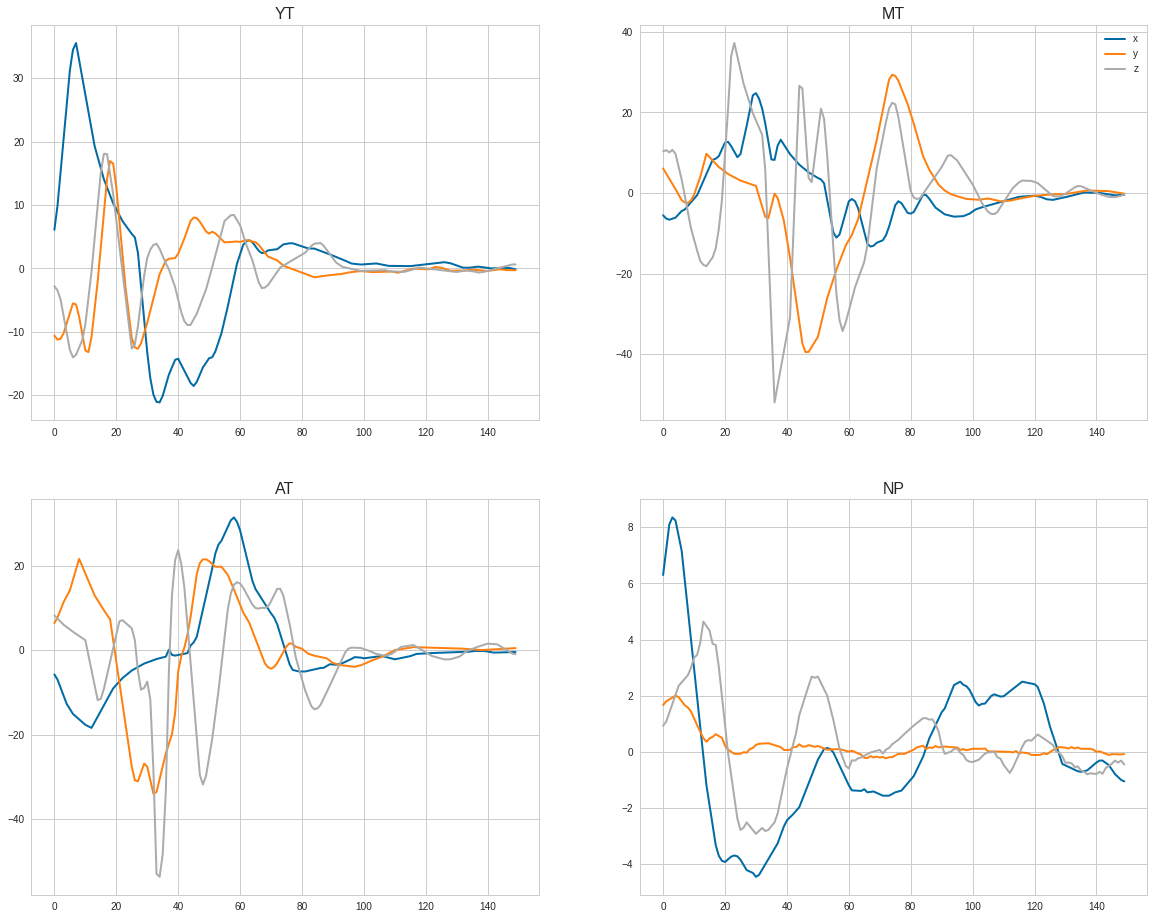

In [77]:
plt.figure(figsize=(20,16))
plt.style.use('tableau-colorblind10')
i = 667
plt.subplot(2,2,1)
plt.plot(X[i].reshape(3, 150).T)
plt.title(names[Y[i].astype(np.int)])
i = 3
plt.subplot(2,2,2)
plt.plot(X[i].reshape(3, 150).T)
plt.title(names[Y[i].astype(np.int)])
plt.legend(['x', 'y', 'z'])
i = 500
plt.subplot(2,2,3)
plt.plot(X[i].reshape(3, 150).T)
plt.title(names[Y[i].astype(np.int)])
i = 20
plt.subplot(2,2,4)
plt.plot(X[i].reshape(3, 150).T)
plt.title(names[Y[i].astype(np.int)])
plt.show()

# Simple multy layer perceptron

Multy layer perceptron consist of 5 sequential layers with hidden size (450, 1024, 256, 128, 5), sigmoid and relu activations.
Training history on figure.

In [12]:
mlp = Sequential([
    Dense(450, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='sigmoid'),
    Dense(5, activation='sigmoid')
])

mlp.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
plot_model(mlp)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [14]:
mlp_history = mlp.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=100, batch_size=16,  verbose=1)

Epoch 1/100
107/107 [==============================] - 1s 7ms/step - loss: 1.1945 - accuracy: 0.5372 - val_loss: 0.5212 - val_accuracy: 0.8396
Epoch 2/100
107/107 [==============================] - 0s 4ms/step - loss: 0.4718 - accuracy: 0.8505 - val_loss: 0.4175 - val_accuracy: 0.8538
Epoch 3/100
107/107 [==============================] - 0s 4ms/step - loss: 0.2955 - accuracy: 0.8999 - val_loss: 0.3258 - val_accuracy: 0.8774
Epoch 4/100
107/107 [==============================] - 0s 4ms/step - loss: 0.1740 - accuracy: 0.9496 - val_loss: 0.4620 - val_accuracy: 0.8443
Epoch 5/100
107/107 [==============================] - 0s 4ms/step - loss: 0.1628 - accuracy: 0.9471 - val_loss: 0.3680 - val_accuracy: 0.9057
Epoch 6/100
107/107 [==============================] - 0s 4ms/step - loss: 0.1125 - accuracy: 0.9677 - val_loss: 0.3543 - val_accuracy: 0.9198
Epoch 7/100
107/107 [==============================] - 0s 4ms/step - loss: 0.1003 - accuracy: 0.9696 - val_loss: 0.5012 - val_accuracy: 0.8538

Training 100 epochs process for a simple multilayer peceptron. 

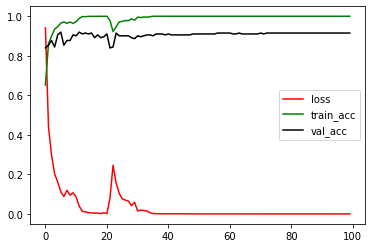

In [15]:
plt.plot(mlp_history.history['loss'],  color='red')
plt.plot(mlp_history.history['accuracy'],  color='green')
plt.plot(mlp_history.history['val_accuracy'], color='black')
plt.legend(['loss', 'train_acc', 'val_acc'])

Here we see difference between train and validation accuracy and small loss.
This means, that linear model is overfitting.
To avoid this we try more complex model - 1D convolution network.

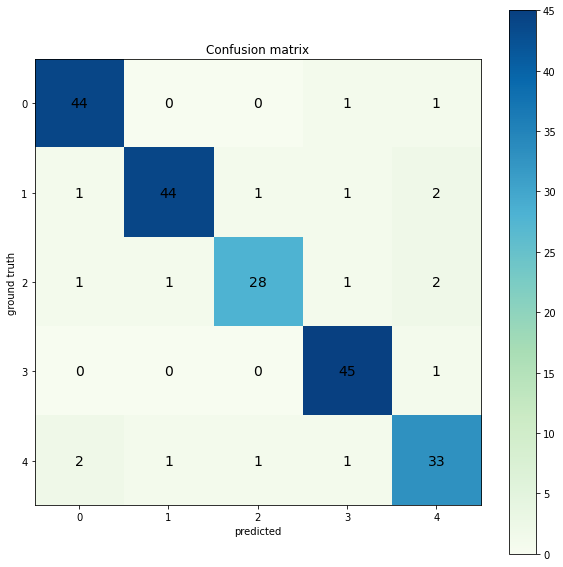

In [16]:
predictions = np.argmax(mlp.predict(X_val), axis=1)
gt = y_val.astype(np.int)
confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

In [17]:
mlp_metrics = calc_metrics(confusion_matrix)
mlp_metrics = pd.DataFrame(mlp_metrics)
mlp_metrics

,precision,recall,F1-score
0,0.916667,0.956522,0.936170
1,0.956522,0.897959,0.926316
2,0.933333,0.848485,0.888889
3,0.918367,0.978261,0.947368
4,0.846154,0.868421,0.857143


# Convolution Net from Keras tutorial

In [18]:
X_train, y_train, X_val, y_val = random_split_train_val(X, Y, 212)
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

In [19]:
conv_model_1 = Sequential([
    Input(X_train.shape[1:]),
    Conv1D(filters=64, kernel_size=3, padding='same'),
    BatchNormalization(),
    ReLU(),
    
    Conv1D(filters=64, kernel_size=3, padding='same'),
    BatchNormalization(),
    ReLU(),
    
    Conv1D(filters=64, kernel_size=3, padding='same'),
    BatchNormalization(),
    ReLU(),
    
    GlobalAveragePooling1D(),
    Dense(num_classes, activation='sigmoid')
])

optim = optimizers.Adam(2e-3)

conv_model_1.compile(loss='sparse_categorical_crossentropy', 
              optimizer=optim, metrics=['accuracy'])

In [20]:
history = conv_model_1.fit(X_train, y_train, validation_data=(X_val, y_val), 
                    epochs=100, batch_size=64,  verbose=1)

Epoch 1/100
27/27 [==============================] - 2s 37ms/step - loss: 1.4133 - accuracy: 0.4572 - val_loss: 1.6511 - val_accuracy: 0.2972
Epoch 2/100
27/27 [==============================] - 1s 31ms/step - loss: 1.2231 - accuracy: 0.5536 - val_loss: 1.5018 - val_accuracy: 0.2547
Epoch 3/100
27/27 [==============================] - 1s 31ms/step - loss: 1.0957 - accuracy: 0.6476 - val_loss: 1.3294 - val_accuracy: 0.3915
Epoch 4/100
27/27 [==============================] - 1s 31ms/step - loss: 1.0234 - accuracy: 0.6440 - val_loss: 1.3664 - val_accuracy: 0.4104
Epoch 5/100
27/27 [==============================] - 1s 31ms/step - loss: 0.9446 - accuracy: 0.6946 - val_loss: 1.3994 - val_accuracy: 0.4292
Epoch 6/100
27/27 [==============================] - 1s 31ms/step - loss: 0.9017 - accuracy: 0.6907 - val_loss: 1.2475 - val_accuracy: 0.4906
Epoch 7/100
27/27 [==============================] - 1s 32ms/step - loss: 0.8767 - accuracy: 0.6925 - val_loss: 1.5371 - val_accuracy: 0.4481
Epoch 

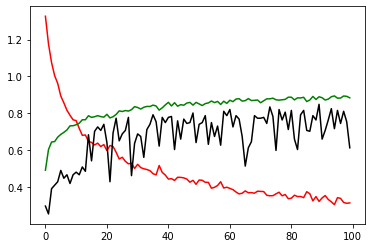

In [21]:
plt.plot(history.history['loss'],  color='red')
plt.plot(history.history['accuracy'],  color='green')
plt.plot(history.history['val_accuracy'], color='black')

Here we see big loss, low test accuracy and unstable predictions.  
Let's some tune network architechture.

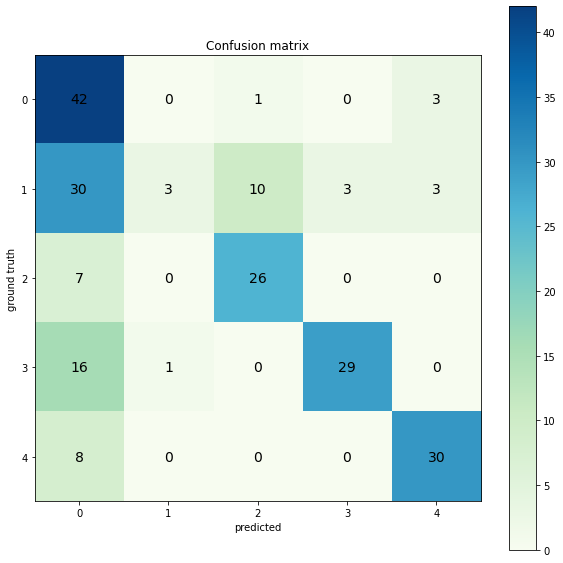

In [22]:
predictions = np.argmax(conv_model_1.predict(X_val), axis=1)
gt = y_val.astype(np.int)
confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

In [23]:
conv_metrics_1 = calc_metrics(confusion_matrix)
conv_metrics_1 = pd.DataFrame(conv_metrics_1)
conv_metrics_1

,precision,recall,F1-score
0,0.407767,0.913043,0.563758
1,0.750000,0.061224,0.113208
2,0.702703,0.787879,0.742857
3,0.906250,0.630435,0.743590
4,0.833333,0.789474,0.810811


# 2D Convolution Net with 2 layers

In [24]:
X = train_dataset[:,0:450]
Y = train_dataset[:,600]
X_train, y_train, X_val, y_val = random_split_train_val(X, Y, 212)

X_train = X_train.reshape(-1, 3, 150, 1)
X_val = X_val.reshape(-1, 3, 150, 1)

In [25]:
# best hyperparameters from grid search @see ConvNet_Grid_Search.ipynb
lr = 0.031623
n_filters_1 = 72
n_filters_2 = 88
kernel_size = 52
momentum = 0.99
batch_size = 80

In [26]:
conv_model_2 = Sequential([
        Input(X_train.shape[1:]),
        Conv2D(filters=n_filters_1, kernel_size=(2, kernel_size)),
        BatchNormalization(),
        ReLU(),

        Conv2D(filters=n_filters_2, kernel_size=2),
        BatchNormalization(),
        ReLU(),

        GlobalAveragePooling2D(),
        Dense(num_classes, activation='sigmoid')
    ])

optim = optimizers.SGD(lr, momentum)
    
conv_model_2.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=optim, metrics=['accuracy'])

conv_history_2 = conv_model_2.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=100, batch_size=batch_size)

Epoch 1/100
22/22 [==============================] - 1s 18ms/step - loss: 1.1285 - accuracy: 0.5795 - val_loss: 5.1575 - val_accuracy: 0.7311
Epoch 2/100
22/22 [==============================] - 0s 14ms/step - loss: 0.5745 - accuracy: 0.8062 - val_loss: 7.8519 - val_accuracy: 0.7028
Epoch 3/100
22/22 [==============================] - 0s 13ms/step - loss: 0.4297 - accuracy: 0.8475 - val_loss: 10.4248 - val_accuracy: 0.6132
Epoch 4/100
22/22 [==============================] - 0s 13ms/step - loss: 0.3769 - accuracy: 0.8586 - val_loss: 8.6882 - val_accuracy: 0.6179
Epoch 5/100
22/22 [==============================] - 0s 13ms/step - loss: 0.3447 - accuracy: 0.8903 - val_loss: 6.1260 - val_accuracy: 0.7075
Epoch 6/100
22/22 [==============================] - 0s 13ms/step - loss: 0.2636 - accuracy: 0.8955 - val_loss: 6.8476 - val_accuracy: 0.6557
Epoch 7/100
22/22 [==============================] - 0s 13ms/step - loss: 0.2678 - accuracy: 0.9086 - val_loss: 3.6458 - val_accuracy: 0.6792
Epoch

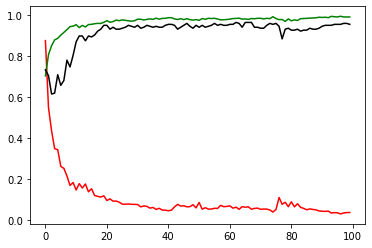

In [27]:
plt.plot(conv_history_2.history['loss'],  color='red')
plt.plot(conv_history_2.history['accuracy'],  color='green')
plt.plot(conv_history_2.history['val_accuracy'], color='black')

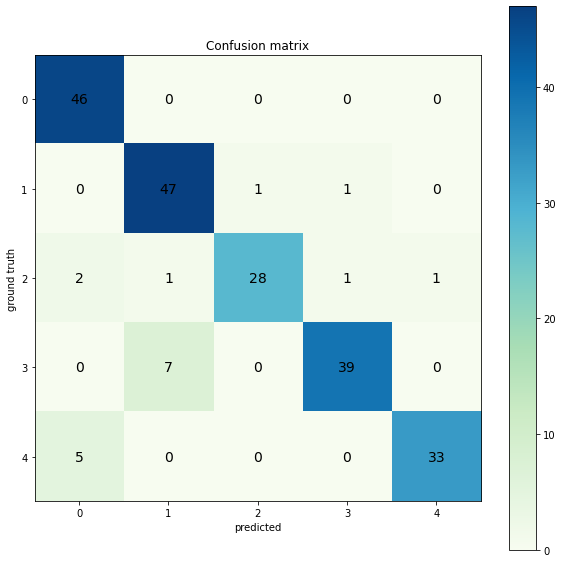

In [28]:
predictions = np.argmax(conv_model_2.predict(X_val), axis=1)
gt = y_val.astype(np.int)
confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

In [29]:
conv_metrics_2 = calc_metrics(confusion_matrix)
conv_metrics_2 = pd.DataFrame(conv_metrics_2)
conv_metrics_2

,precision,recall,F1-score
0,0.867925,1.000000,0.929293
1,0.854545,0.959184,0.903846
2,0.965517,0.848485,0.903226
3,0.951220,0.847826,0.896552
4,0.970588,0.868421,0.916667


# 2D Convolution Net with 4 layers

In [30]:
X = train_dataset[:,0:450]
Y = train_dataset[:,600]
X_train, y_train, X_val, y_val = random_split_train_val(X, Y, 212)

X_train = X_train.reshape(-1, 3, 150, 1)
X_val = X_val.reshape(-1, 3, 150, 1)

In [31]:
# RANDOM hyperparameters 
lr = 0.01
n_filters_1 = 32
n_filters_2 = 64
n_filters_3 = 96
kernel_size = 32
momentum = 0.99
batch_size = 64

In [78]:
conv_model_3 = Sequential([
        Input(X_train.shape[1:]),
        Conv2D(filters=n_filters_1, kernel_size=(2, kernel_size), padding="same" ),
        BatchNormalization(),
        ReLU(),

        Conv2D(filters=n_filters_2, kernel_size=2, padding="same"),
        BatchNormalization(),
        ReLU(),
    
        Conv2D(filters=n_filters_2, kernel_size=2, padding="same"),
        BatchNormalization(),
        ReLU(),
    
        Conv2D(filters=n_filters_3, kernel_size=2),
        BatchNormalization(),
        ReLU(),

        GlobalAveragePooling2D(),
        Dense(num_classes, activation='sigmoid')
    ])

optim = optimizers.SGD(lr, momentum)
    
conv_model_3.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=optim, metrics=['accuracy'])

conv_history_3 = conv_model_3.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=100, batch_size=batch_size)

Epoch 1/100
27/27 [==============================] - 2s 44ms/step - loss: 1.3203 - accuracy: 0.5007 - val_loss: 2.8053 - val_accuracy: 0.2358
Epoch 2/100
27/27 [==============================] - 1s 39ms/step - loss: 0.7066 - accuracy: 0.7730 - val_loss: 4.2039 - val_accuracy: 0.2925
Epoch 3/100
27/27 [==============================] - 1s 39ms/step - loss: 0.4672 - accuracy: 0.8361 - val_loss: 5.8431 - val_accuracy: 0.4387
Epoch 4/100
27/27 [==============================] - 1s 39ms/step - loss: 0.3735 - accuracy: 0.8701 - val_loss: 2.5686 - val_accuracy: 0.7028
Epoch 5/100
27/27 [==============================] - 1s 39ms/step - loss: 0.2938 - accuracy: 0.8900 - val_loss: 8.0841 - val_accuracy: 0.4623
Epoch 6/100
27/27 [==============================] - 1s 39ms/step - loss: 0.2367 - accuracy: 0.9297 - val_loss: 3.7242 - val_accuracy: 0.6981
Epoch 7/100
27/27 [==============================] - 1s 39ms/step - loss: 0.2152 - accuracy: 0.9101 - val_loss: 8.4919 - val_accuracy: 0.4481
Epoch 

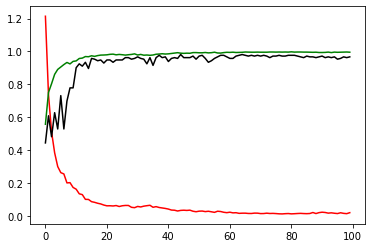

In [33]:
plt.plot(conv_history_3.history['loss'],  color='red')
plt.plot(conv_history_3.history['accuracy'],  color='green')
plt.plot(conv_history_3.history['val_accuracy'], color='black')

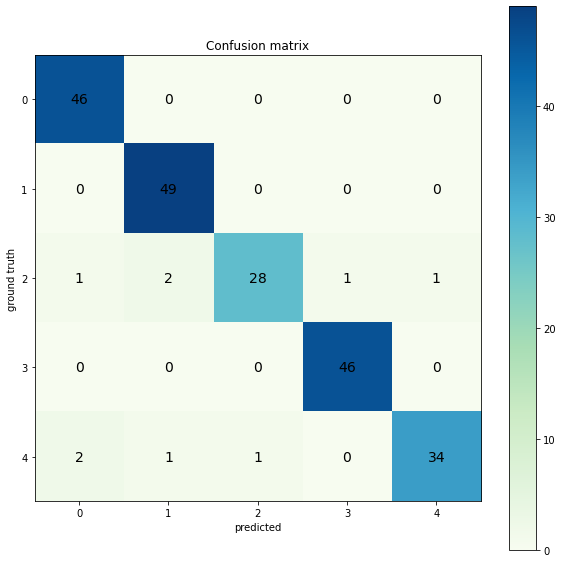

In [34]:
predictions = np.argmax(conv_model_3.predict(X_val), axis=1)
gt = y_val.astype(np.int)
confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

In [35]:
conv_metrics_3 = calc_metrics(confusion_matrix)
conv_metrics_3 = pd.DataFrame(conv_metrics_3)
conv_metrics_3

,precision,recall,F1-score
0,0.938776,1.000000,0.968421
1,0.942308,1.000000,0.970297
2,0.965517,0.848485,0.903226
3,0.978723,1.000000,0.989247
4,0.971429,0.894737,0.931507


In [36]:
# scores for all models and classes
pd.concat([mlp_metrics, conv_metrics_1, conv_metrics_2, conv_metrics_3], axis=1)

,precision,recall,F1-score,precision,recall,F1-score,precision,recall,F1-score,precision,recall,F1-score
0,0.916667,0.956522,0.936170,0.407767,0.913043,0.563758,0.867925,1.000000,0.929293,0.938776,1.000000,0.968421
1,0.956522,0.897959,0.926316,0.750000,0.061224,0.113208,0.854545,0.959184,0.903846,0.942308,1.000000,0.970297
2,0.933333,0.848485,0.888889,0.702703,0.787879,0.742857,0.965517,0.848485,0.903226,0.965517,0.848485,0.903226
3,0.918367,0.978261,0.947368,0.906250,0.630435,0.743590,0.951220,0.847826,0.896552,0.978723,1.000000,0.989247
4,0.846154,0.868421,0.857143,0.833333,0.789474,0.810811,0.970588,0.868421,0.916667,0.971429,0.894737,0.931507
